## Plotting AirBnB Availability in London

In this workbook, we're going to display data about AirBnB rental availability in London, contrasted with Index of Multiple Deprivation (2015), Barriers to Housing and Services data.

The IMD data are [available](https://data.london.gov.uk/dataset/indices-of-deprivation-2015) from the London Datastore, at the [LSOA](http://www.datadictionary.nhs.uk/data_dictionary/nhs_business_definitions/l/lower_layer_super_output_area_de.asp?shownav=1) level. A [refresher](http://www.datadictionary.nhs.uk/data_dictionary/nhs_business_definitions/l/lower_layer_super_output_area_de.asp?shownav=1):

>Lower Layer Super Output Areas are built from groups of contiguous Output Areas and have been automatically generated to be as consistent in population size as possible, and typically contain from four to six Output Areas. The minimum population is 1000 and the mean is 1500.

The AirBnB data have been processed into a Shapefile by converting the original coordinates to `Point` types, before building a `GeoDataFrame` and assigning the `OSGB36` crs.

In [1]:
import shapely
import pandas as pd
import geopandas as gp
from shapely.geometry import Point

import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba
from matplotlib.ticker import FormatStrFormatter
from matplotlib.offsetbox import AnchoredOffsetbox, TextArea, HPacker, VPacker
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
%matplotlib inline

import pysal as ps
import numpy as np

/Users/sth/dev/Geopython/venv/lib/python2.7/site-packages/matplotlib/font_manager.py:279: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


These are styling options. Omit them or alter them to suit.

In [2]:
from matplotlib import rc
rc('font', **{'family':'sans-serif',
    'sans-serif':['Helvetica'],
    'monospace': ['Inconsolata'],
    'serif': ['Adobe Garamond Pro']}
  )

Use LaTeX for styling. Omit this if you like.

In [3]:
rc('text', **{'usetex': True})
rc('text', **{'latex.preamble': '\\usepackage{sfmath}'})

We're going to load processed rental data which originally came from [Inside Airbnb](http://insideairbnb.com)  
We're also going to load some Borough overlays, and Index of Multiple Deprivation (IMD) data

In [4]:
abb_gdf = gp.read_file("data/listings")
imd_gdf = gp.read_file("data/imd_joined")
boroughs_gdf = gp.read_file("data/neighbourhoods.geojson")

Perform a spatial join of AirBnB rentals (left) to LSOAs (right)

In [8]:
merged = gp.tools.sjoin(
    abb_gdf, imd_gdf, 
    how="inner",
)

Now merge aggregated (counted) rentals to LSOA polygon rows

In [9]:
imd_gdf = imd_gdf.merge(
    merged['LSOA11NM'].value_counts().to_frame(),
    how='left',
    left_on='LSOA11NM', right_index=True)
# rename count column
imd_gdf.rename(columns={"LSOA11NM_y": 'Rental_Count'}, inplace=True)

Create decile bins. Ratio can also be used as a percentage proxy

In [10]:
imd_gdf['ABB_Ratio'] = imd_gdf['Rental_Count'] / imd_gdf['HHOLDS']
q10 = ps.Quantiles(imd_gdf.dropna().ABB_Ratio, k=10)

We want to highlight the boroughs containing the 25 LSOAs with the highest ratio of rental availability to households

In [11]:
boroughs = imd_gdf.sort_values(by='ABB_Ratio', ascending=False).iloc[:24].LAD11NM.unique()

Now, on to the plotting. A lot of rental data are missing, and we're lacking a good model with which to infer these, so I've decided *not* to plot those LSOAs for which we don't know anything.

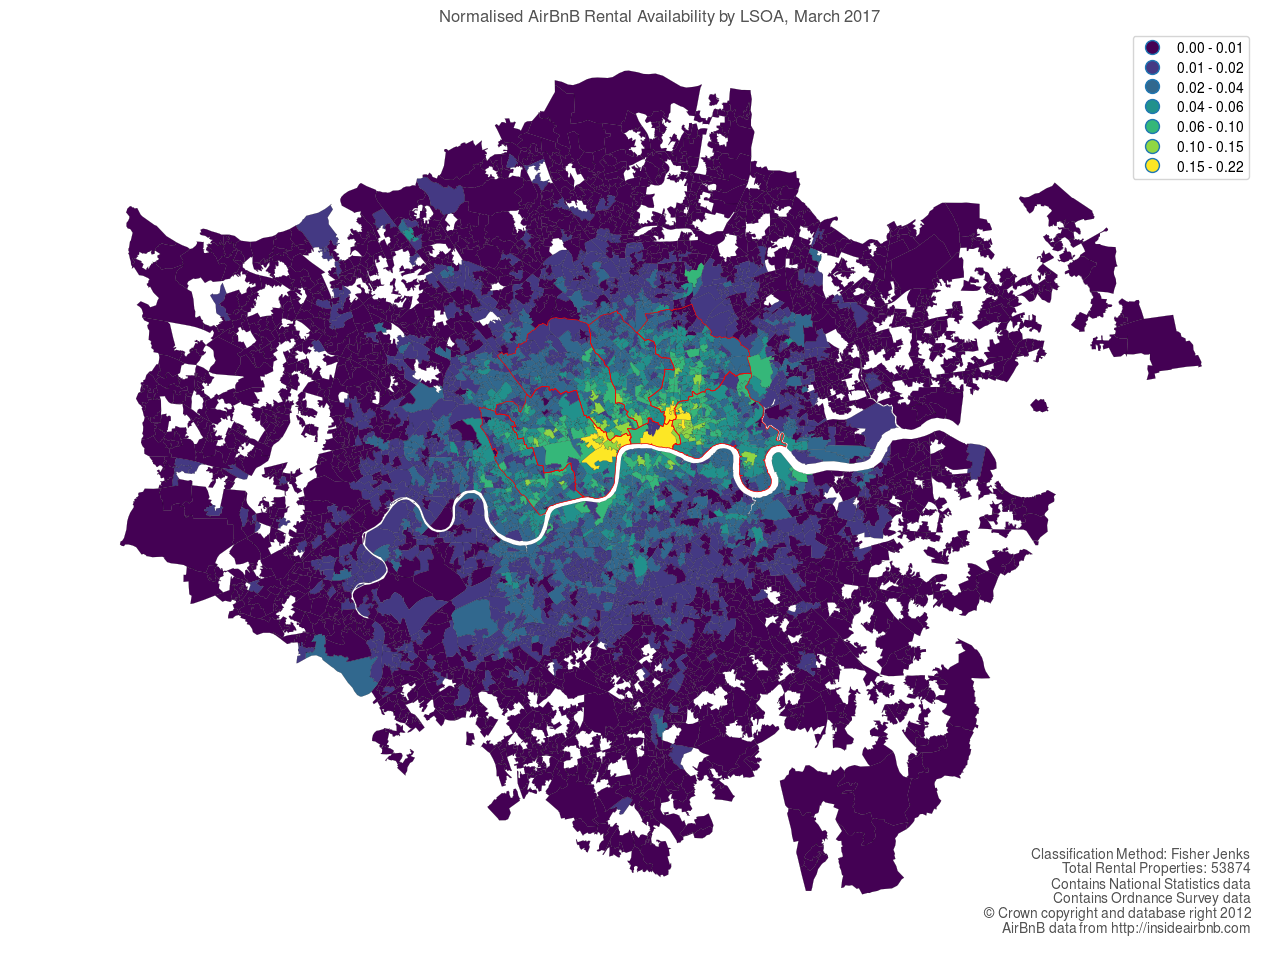

In [16]:
plt.clf()
fig, ax = plt.subplots(
    1,
    figsize=(16., 12.),
    dpi=100,
    subplot_kw=dict(aspect='equal'),
)

# this will plot Fisher Jenks of normalised rental availability
base = imd_gdf.dropna().plot(
    ax=ax,
    alpha=1.,
    column='ABB_Ratio',
    scheme="fisher_jenks",
    k=7,
    cmap="viridis",
    linewidth=0.1,
    edgecolor='black',
    legend=True,
)


# Display boroughs with most AirBnB
top = boroughs_gdf.to_crs({'init': 'epsg:27700'}).loc[boroughs_gdf['neighbourhood'].isin(boroughs)].plot(
    ax=ax,
    linewidth=.5,
    color='None',
    edgecolor='red'
)

_ = ax.axis('off')

ax.set_title("Normalised AirBnB Rental Availability by LSOA, March 2017", color='#555555')

# Display data sources
smallprint = ax.text(
    .995, 0,
    'Classification Method: Fisher Jenks\nTotal Rental Properties: %s\nContains National Statistics data\nContains Ordnance Survey data\n$\copyright$ Crown copyright and database right 2012\nAirBnB data from http://insideairbnb.com' % int(imd_gdf['Rental_Count'].sum()),
    ha='right', va='bottom',
    size=10,
    color='#555555',
    transform=ax.transAxes)

plt.show()

###  Next, we're going to plot the Access to Housing and Services scores of the boroughs with the highest AirBnB rental availability. A lower score means worse access.

Join boroughs to top AirBnB LSOAs

In [17]:
lsoa_boroughs = gp.sjoin(
    imd_gdf.to_crs({'init': 'epsg:27700'}),
    boroughs_gdf.to_crs({'init': 'epsg:27700'}),
    how="inner", op='intersects'
)

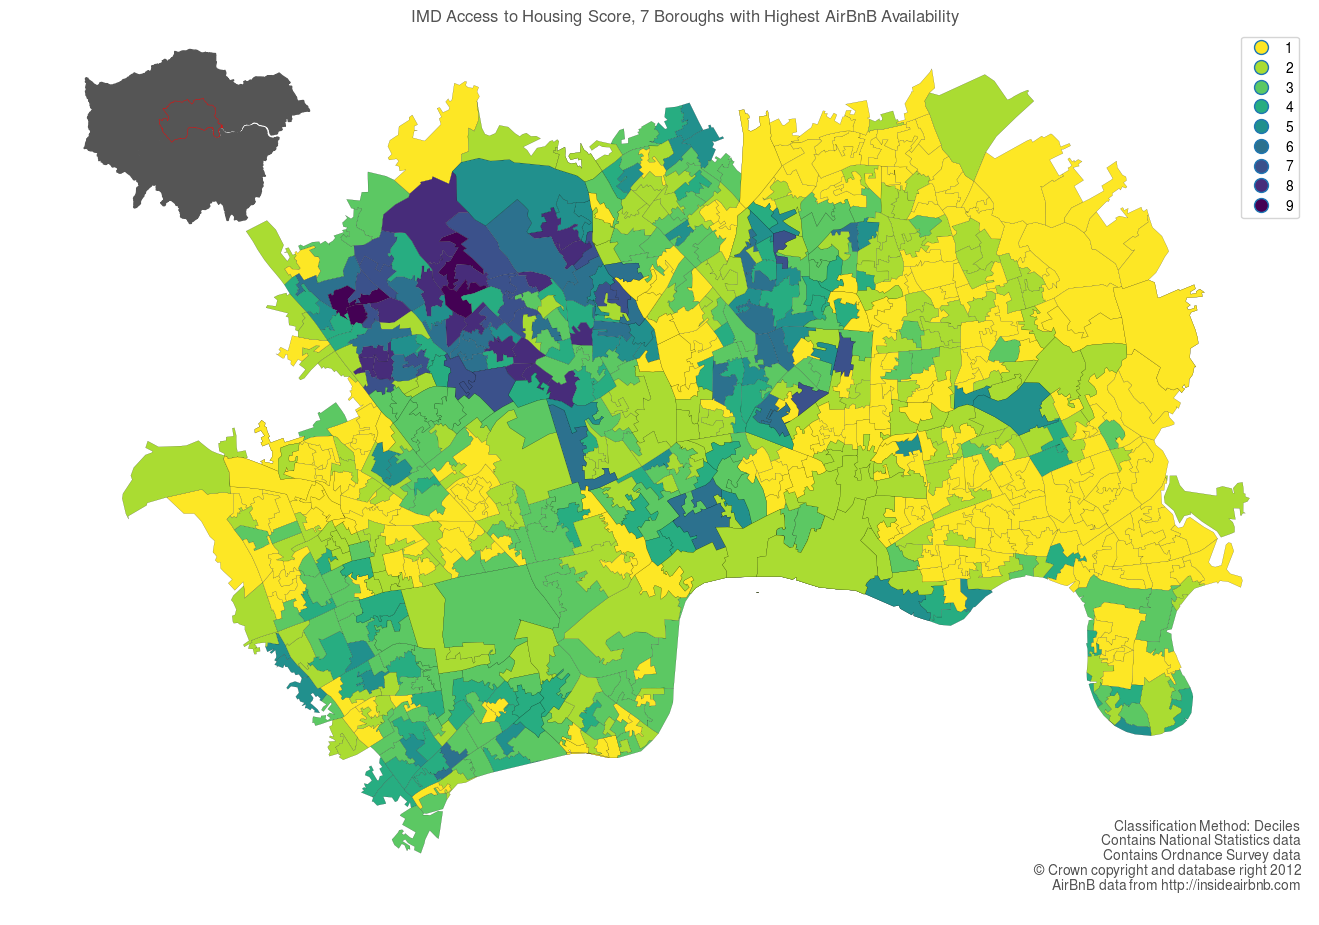

In [18]:
plt.clf()
fig, ax = plt.subplots(
    1,
    figsize=(16., 12.),
    dpi=100,
    subplot_kw=dict(aspect='equal'),
)

lsoa_boroughs.loc[lsoa_boroughs['neighbourhood'].isin(boroughs)].plot(
    categorical=True,
    ax=ax,
    alpha=1.,
    column='Hou_Dec',
    k=10,
    cmap="viridis_r",
    linewidth=0.1,
    edgecolor='black',
    legend=True,   
)
_ = ax.axis('off')

ax.set_title("IMD Access to Housing Score, %s Boroughs with Highest AirBnB Availability" % len(boroughs), color='#555555')

smallprint = ax.text(
    .995, 0,
    'Classification Method: Deciles\nContains National Statistics data\nContains Ordnance Survey data\n$\copyright$ Crown copyright and database right 2012\nAirBnB data from http://insideairbnb.com',
    ha='right', va='bottom',
    size=10,
    color='#555555',
    transform=ax.transAxes)

axins = inset_axes(
    ax,
    width="20%", # width = % of parent_bbox
    height=2.0,
    loc=2,
    axes_kwargs={'aspect': 'equal', 'facecolor': '#555555'}
)

inset= imd_gdf.plot(
    ax=axins,
    color='#555555',
    facecolor='#555555',
    edgecolor='#555555',
    legend=False,
)

union = boroughs_gdf.loc[boroughs_gdf['neighbourhood'].isin(boroughs)].to_crs({'init': 'epsg:27700'}).unary_union
union_gdf = gp.GeoDataFrame(geometry=[union])
union_gdf.plot(ax=axins, linewidth=0.3, edgecolor='red', color='none')

_ = axins.axis('off')
plt.show()